In [2]:
"""
    Health Information Privacy Lab
    This notebook is intended to run experiments and generate the data to be used by another notebook

    pre-requisites:
        - pandas_risk This is a custom framework that will compute risk for a given dataset
        - google-cloud-bigquery
        - numpy
"""
import pandas as pd
import numpy as np
from pandas_risk import *
from time import time
import os
#
#-- Loading the dataset
class Logger :
    cache = []
    @staticmethod
    def clear():
        Logger.cache = []
    @staticmethod
    def log(**args) :
        Logger.cache.append(args)
    
SQL_CONTROLLED="SELECT person_id,birth_datetime,city,zip,state,race,gender FROM deid_risk.basic_risk60k"
SQL_REGISTERED = "SELECT  person_id,birth_datetime,city,zip,state,race,gender FROM deid_risk.basic_deid_risk60k"
dfr = pd.read_gbq(SQL_REGISTERED,private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json')
dfc = pd.read_gbq(SQL_CONTROLLED,private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json')



In [99]:

#
FLAG='REGISTERED-TIER-1'
if FLAG == 'REGISTERED-TIER' :
    Yi = pd.DataFrame(dfr)
    FOLDER='registered'
else:
    Yi = pd.DataFrame(dfc)
    FOLDER='controlled'
Yi = Yi.fillna(' ')
N = 5
N_ = str(N)
SUFFIX = FOLDER+'-tier-'+str(N)+'-experiment.xlsx'
PATH = os.sep.join(['out',SUFFIX])


columns = list(set(Yi.columns.tolist()) - set(['person_id']))
merged_columns = list(columns)+['field_count']
m = {}
p = pd.DataFrame()
n = 0
y_i= pd.DataFrame({"group_size":Yi.groupby(columns,as_index=False).size()}).reset_index()
#.deid.risk(id='person_id',quasi_id=columns)
for index in np.arange(5,105,5):
    for n in np.repeat(index,N) :
#         np.random.seed( np.random.randint(0,int(time())+np.random.randint(0,1000)+index+n ) 
        #
        # we will randomly sample n% rows from the dataset
        i = np.random.choice(Yi.shape[0],((Yi.shape[0] * n)/100),replace=False)
        x_i= pd.DataFrame(Yi).loc[i] 
        risk = x_i.deid.risk(id='person_id',quasi_id = columns)
        x_i = pd.DataFrame({"group_size":x_i.groupby(columns,as_index=False).size()}).reset_index()
        
#         y_i= pd.DataFrame(Yi).deid.risk(id='person_id',quasi_id=columns)


        r = pd.merge(x_i,y_i,on=columns,how='inner')
        if r.shape[0] == 0 :
            print 'skipping ',n
            continue
        r['marketer'] = r.apply(lambda row: (row.group_size_x / np.float64(row.group_size_y)) /np.sum(x_i.group_size) ,axis=1)
        r['sample %'] = np.repeat(n,r.shape[0])
        r['tier'] = np.repeat(FOLDER,r.shape[0])
        r['sample marketer'] =  np.repeat(risk['marketer'].values[0],r.shape[0])
#         r['patient_count'] = np.repeat(r.shape[0],r.shape[0])
        r = r.groupby(['sample %','tier','sample marketer'],as_index=False).sum()[['sample %','marketer','sample marketer','tier']]
#         r['marketer'] = r.apply(lambda row: (row.group_size_x / row.group_size_y) / row.patient_count_x,axis=1 )
#         r = r.groupby(columns+['marketer_x'],as_index=False).sum()[columns+['marketer','marketer_x']]
#         r['sample %'] = np.repeat(n,r.shape[0])
#         r['tier'] = np.repeat(FOLDER,r.shape[0])
        p = p.append(r)

writer = pd.ExcelWriter(PATH,engine='xlsxwriter')
p = p.rename(columns={'marketer_x':'sample marketer'})
p.index = np.arange(p.shape[0]).astype(np.int64)
p.to_excel(writer,FOLDER)
writer.save()
p.head()    

,sample %,marketer,sample marketer,tier
0,5,0.974945,0.981364,controlled
1,5,0.975513,0.981996,controlled
2,5,0.975798,0.980733,controlled
3,5,0.976364,0.981996,controlled
4,5,0.976364,0.981996,controlled


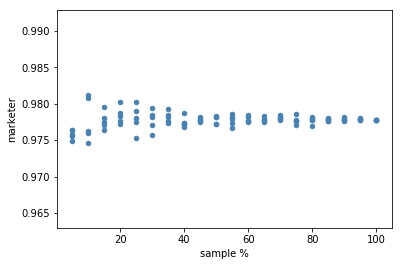

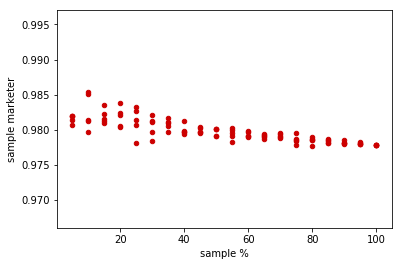

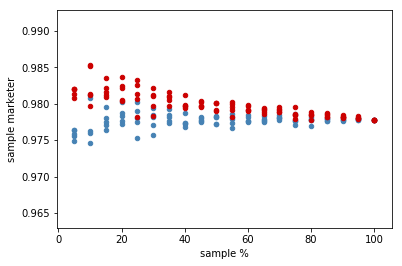

In [100]:
p.plot(kind='scatter',x='sample %',y='marketer', c = '#4682B4')
p.plot(kind='scatter',x='sample %',y = 'sample marketer', c='#CC0000')
ax = p.plot(kind='scatter',x='sample %',y='marketer', c = '#4682B4')
p.plot(kind='scatter',x='sample %',y = 'sample marketer', c='#CC0000',ax=ax)

In [ ]:
"""
    This experiment consists in :
    1: randomly selecting x % of the records to be sampled
    2: running a group by on the sample
    3: calling groupby on the population which th
"""
SQL_ORIGINAL="SELECT * FROM deid_risk.risk_60k2"
SQL_DEID = "SELECT * FROM deid_risk.deid_risk_60k limit 20000"
# df = pd.read_gbq(SQL_DEID,private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json')

#
FLAG='REGISTERED-TIER-9'
if FLAG == 'REGISTERED-TIER' :
    Yi = pd.DataFrame(dfr)
    FOLDER='registered'
else:
    Yi = pd.DataFrame(dfc)
    FOLDER='controlled'
N = 20
N_ = str(N)
SUFFIX = FOLDER+'-tier-'+str(N)+'-experiment.xlsx'
PATH = os.sep.join(['out',SUFFIX])


columns = list(set(Yi.columns.tolist()) - set(['person_id']))
merged_columns = list(columns)+['field_count']
m = {}
p = pd.DataFrame()
n = 0
y_i= pd.DataFrame(Yi).deid.risk(id='person_id',quasi_id=columns)
for index in np.arange(5,105,5):
#     np.random.seed( int(time())+np.random.randint(0,100)+index ) 
#     n = np.random.randint(10,35) #-- randomly pick a number within an interval
    
    for n in np.repeat(index,20) :
#         np.random.seed( np.random.randint(0,int(time())+np.random.randint(0,1000)+index+n ) 
        #
        # we will randomly sample n% rows from the dataset
        i = np.random.choice(Yi.shape[0],((Yi.shape[0] * n)/100),replace=False)
        x_i= pd.DataFrame(Yi).loc[i].deid.risk(id='person_id',quasi_id = columns)
        
#         y_i= pd.DataFrame(Yi).deid.risk(id='person_id',quasi_id=columns)


        r = pd.merge(x_i,y_i,on=merged_columns,how='inner')
        if r.shape[0] == 0 :
            print 'skipping ',n
            continue

        r['marketer'] = r.apply(lambda row: (row.group_size_x / row.group_size_y) / row.patient_count_x,axis=1 )
        r = r.groupby(columns+['marketer_x'],as_index=False).sum()[columns+['marketer','marketer_x']]
        r['sample %'] = np.repeat(n,r.shape[0])
        r['tier'] = np.repeat(FOLDER,r.shape[0])
        p = p.append(r)

writer = pd.ExcelWriter(PATH,engine='xlsxwriter')
p = p.rename(columns={'marketer_x':'sample marketer'})
p.index = np.arange(p.shape[0]).astype(np.int64)
p.to_excel(writer,FOLDER)
writer.save()
p.head()

In [ ]:
ax = p.plot(kind='scatter',x='sample %',y='marketer',c='r',ylim=[p.marketer.min(),p.marketer.max()])
p.plot(kind='scatter',x='sample %',y='sample marketer',c='#4682B4')
ax = p.plot(kind='scatter',x='sample %',y='marketer',c='r')
p.plot(kind='scatter',x='sample %',y='sample marketer',c='#4682B4',ax=ax)

_p = pd.DataFrame(p)

In [ ]:
p.head()

# writer = pd.ExcelWriter('out/foo.xlsx',engine='xlsxwriter')
# workbook = writer.book
# r.groupby('field_count',as_index=False).sum()[['field_count','marketer_x']].to_excel(writer,'page-0')
# chart = workbook.add_chart({'type':'line'})
# o = r.groupby('field_count',as_index=False).sum()[['field_count','marketer_x']]
# # values = o.marketer_x.tolist()
# # values = [['page-0',item] for item in values]
# # chart.add_series({"values":values})
# # chart.add_series({'values':'=page-0!$B$2:$B$5'})

# worksheet = writer.sheets['page-0']
# worksheet.insert_chart('G2',chart)
# writer.save()

str(10)


In [ ]:
help(chart.add_series)

In [ ]:
cols = list(set(dfr.columns.tolist()) - set(['person_id'])) + ['field_count']
r = pd.merge(x_i,y_i,on=cols,how='inner')
r['marketer'] = r.apply(lambda row: (row.group_count_x/row.group_count_y)/row.patient_count_y ,axis=1)
# r['field_count'] = r['field_count_x']
o = r.groupby(cols,as_index=False).sum()[cols+['marketer']]
o.groupby(['field_count'],as_index=False).mean()
# o.groupby('field_count',as_index=False).mean().plot.line(x='field_count',y='marketer')
# r.head()
# N = r.patient_count_y.mean()
# r['marketer'] = r.apply(lambda row: row.group_count_x / row.group_count_y,axis=1)
# m  = r.groupby(['field_count'],as_index=False).mean()[['field_count','marketer']]
# m.marketer = m.marketer / N
# m.groupby(['field_count']).mean().plot.line()


In [ ]:
p.to_csv('out/x-2/single-runs-deid.csv',index=False)
p.groupby(['sample %']).mean()['marketer'].plot.line()
p.groupby(['sample %'],as_index=False).mean().plot.scatter(x='sample %',y='marketer')

In [ ]:
y = pd.DataFrame({"name":['d','e','f','g'],"age":[12,40,20,30],"income":[100,200,300,400]})
x = pd.DataFrame({"name":['a','b','c'],"age":[10,20,40],"income":[120,100,200]})

# x.join(y,how='outer',on='age')
x_ = pd.merge(x,y,on=['age','income'],how='outer')
Logger.log(action='merge',value=x_.shape)
Logger.cache

In [ ]:
#
# EXP_0
# Running the experiment on the Original dataset, with all the attributes
SCHEMA = "deid_risk"
df = pd.read_gbq("select person_id,birth_datetime,race,gender,sex_at_birth, city,state,zip from deid_risk.basic_risk60k ",private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json',
                dialect='standard')

RUNS = 500
FLAG = 'basic-features'
r = df.deid.risk(id='person_id',num_runs=RUNS) #,field_count=11)
# r.to_csv('out/pandas-60k-'+FLAG+'-patients-'+str(RUNS)+'-x-runs.csv')
compiled = r.groupby('field_count',as_index=False)['marketer','prosecutor'].mean()
fi = compiled[['marketer','prosecutor']].plot.line().get_figure()
# fo
# r.plot.line(x='field_count',y='marketer')
compiled = r.groupby('field_count',as_index=False)['field_count','marketer','prosecutor'].mean()
fig_i = r.plot.scatter(x='field_count',y='marketer').get_figure()

In [ ]:
#
# EXP_2 :
# This experiment will run the marketer risk against individual attributes
deid_df = pd.read_gbq("select person_id,birth_datetime,race,gender,sex_at_birth, city,state,zip from deid_risk.basic_deid_risk60k",private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json',
                dialect='standard')
RUNS = 500
FLAG = 'basic-deid-features'
deid_r = deid_df.deid.risk(id='person_id',num_runs=RUNS) #,field_count=11)
# r.to_csv('out/pandas-60k-'+FLAG+'-patients-'+str(RUNS)+'-x-runs.csv')
deid_compiled = deid_r.groupby('field_count',as_index=False)['marketer','prosecutor'].mean()
fo = deid_compiled[['marketer','prosecutor']].plot.line().get_figure()
# fo
# r.plot.line(x='field_count',y='marketer')
# deid_compiled = deid_r.groupby('field_count',as_index=False)['field_count','marketer','prosecutor'].mean()
fig_o = deid_r.plot.scatter(x='field_count',y='marketer').get_figure()

# orig_df = pd.read_gbq("select * from deid_risk.risk_60k2",private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json',
#                 dialect='standard')

In [ ]:
# deid_r.to_csv('out/basic-attributes-deid-data-60k-patients.csv')
# r.to_csv('out/basic-attributes-raw-data-60k-patients.csv')
# deid_r.head()
p = pd.DataFrame()
p = deid_df.deid.risk(id='person_id',quasi_id=['birth_datetime','race','gender','sex_at_birth', 'city','state','zip'])
p = p.append(df.deid.risk(id='person_id',quasi_id=['birth_datetime','race','gender','sex_at_birth', 'city','state','zip']))
p.index = ['deid data','raw data']
p.to_csv('out/basic_run-7-fields.csv')

In [ ]:
cols = deid_r.columns[5:]
deid_r.index = np.arange(deid_r.shape[0]).astype(np.int64)
xdeid_ = deid_r[cols].sum().tolist()
xraw_ = r[cols].sum().tolist()
o = pd.DataFrame()
o['name'] = cols
o['raw'] = xraw_
o['deid']= xdeid_


o


In [ ]:
columns = list( set(orig_df.columns) - set(['person_id']))
xo = pd.DataFrame()
xi = pd.DataFrame()
#
# Let's compute the risk for every attribute given the list of attributes we've gathered
#
for name in columns :
    xo = xo.append(deid_df.deid.risk(id='person_id',quasi_id=[name])[['marketer','prosecutor']],sort=False)
    xi = xi.append(orig_df.deid.risk(id='person_id',quasi_id=[name])[['marketer','prosecutor']],sort=False)


In [ ]:
#
# The following shows how much the deid process has affected each attributes
#

RISK_THRESHOLD = 0.5
xo.index = columns
xi.index = columns

ii = xi[xi.marketer > RISK_THRESHOLD].index
# zo = pd.concat([xi.loc[ii],xo.loc[ii]])

zo = xi.loc[ii].join(xo.loc[ii],rsuffix='_deid')
#
# heatmap for original data
# fig_o = sns.heatmap(xi.loc[ii], cmap='RdYlGn_r', linewidths=0.5, annot=True).get_figure()




In [ ]:
#
# Running the experiment on the DEID dataset, with all the attributes
#
df = pd.read_gbq("select * from deid_risk.deid_risk_60k",private_key='/home/steve/dev/google-cloud-sdk/accounts/curation-test.json',
                dialect='standard')

RUNS = 1500
FLAG = 'deid-full-attr-dataset'
r = df.deid.risk(id='person_id',num_runs=RUNS) #,field_count=11)
# r.to_csv('out/pandas-60k-'+FLAG+'-patients-'+str(RUNS)+'-x-runs.csv')
compiled = r.groupby('field_count',as_index=False)['marketer','prosecutor'].mean()
fo = compiled[['marketer','prosecutor']].plot.line().get_figure()
# fo
# r.plot.line(x='field_count',y='marketer')
compiled = r.groupby('field_count',as_index=False)['field_count','marketer','prosecutor'].mean()
fig_o = r.plot.scatter(x='field_count',y='marketer').get_figure()

In [ ]:
r.groupby('field_count',as_index=False)['marketer','prosecutor'].var()[['marketer','prosecutor']].plot.line()

In [ ]:
#
# We are going to look into the attributes with a risk of a given threshold
# We will run the experiment (varied combinations of the list of attributes)
# The experiment is intended to capture the attributes responsible for increasing the marketer risk
#
DEID_DATASET = 'deid_risk.deid_risk_60k2'
